# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data represents 17 campaigns between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [6]:
import pandas as pd
import time
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix,recall_score, make_scorer
from sklearn import tree

In [7]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



According to its own notes, duration should be discarded since it is not known before a call is initiated and thus cannot be used in a predictive model. In addition, since K-nearest neighbors requires numbers and no categorical features, some categorical features will need to be One Hot Encoded for the model to be trained.
In the meantime, number of employees currently employed is more or less irrelevant to whether the client has a term deposit subscription.
Problem 4 below gives a count of values in each column, revealing there are no additional missing or null values to process.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

According to the accompanying abstract, the business objective of the task is to figure out how to maintain or increase the number of subscribers to long-term deposit accounts. One way to do this is to identify what kinds of customers in the past have subscribed, and modeling can help pinpoint what characteristics correlate with subscribing to a long-term deposit acount, letting future efforts be more focused on those people and thus smaller scale and cheaper to accomplish the same goal of maintaining and growing the customer base for this product. The data also contains data about the time when the customer was contacted, possibly providing insights into when campaigns should be done to maximize its impact.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Looking at all the values in each feature indicates none have any crazy value that wasn't already explained in the description, and so no further tuning is needed.

In [15]:
# for column in df:
#     print(df[column].value_counts())

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

Because this question restricts the dataset to just the bank information features, or those listed under 'bank client data' above, the dataframe will need to drop quite a few columns in addition to the duration feature.

In [18]:
df_client = df.drop(columns=['duration','campaign','pdays','previous','poutcome','emp.var.rate',
                             'cons.price.idx','cons.conf.idx','euribor3m','nr.employed'])
df_client.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,no


In [19]:
#Manual identification of which features are numeric and which are categorical.
numeric_features = ["age"]

categorical_features = ["job","marital", "education", "default","housing","loan",'contact','month','day_of_week']
preprocessor = ColumnTransformer(
    transformers=[
    ("stdscale", StandardScaler(),numeric_features), 
    ("one hot encoder", OneHotEncoder(sparse_output = False),categorical_features)], 
    remainder='passthrough' 
)
preprocessor.set_output(transform = 'pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('stdscale', StandardScaler(), ['age']),
                                ('one hot encoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week'])])

In [20]:
df_transformed = preprocessor.fit_transform(df_client)

In [21]:
X = df_transformed.drop(columns=['remainder__y'])
y = df_transformed['remainder__y']

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 41)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

At the very minimum, the model should beat a baseline of assuming every client having not subscribed to a long term deposit, since 'no' comprises:

In [26]:
baseline_acc = y.value_counts()['no']/y.size

88.7% of all the entries so a simple model of always 'no' gives an accuracy of 88.7%. Any model that does worse than this is probably a waste of computational time and resources.

In [28]:
y.value_counts()

remainder__y
no     36548
yes     4640
Name: count, dtype: int64

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [30]:
start = time.time()
lr = LogisticRegression().fit(X_train,y_train)
end = time.time()

Because the Linear Regression model has an intuitive form as a linear equation with coefficients for each feature, the calculated coefficients for each feature can be pulled out of the model, and since every feature was normalized to the same scale, the relative values of each coefficient tells a story of how important the feature was.

In [32]:
dict_simple_lr = {'Feature Names': lr.feature_names_in_,'Coefficient': lr.coef_[0]}
coef_series = pd.DataFrame(dict_simple_lr)
print(coef_series.sort_values(by=['Coefficient'],ascending=False))


                                     Feature Names  Coefficient
41                      one hot encoder__month_mar     1.020800
38                      one hot encoder__month_dec     0.861129
45                      one hot encoder__month_sep     0.841021
44                      one hot encoder__month_oct     0.830050
9                     one hot encoder__job_student     0.761442
6                     one hot encoder__job_retired     0.409399
34               one hot encoder__contact_cellular     0.307768
12                    one hot encoder__job_unknown     0.161394
21           one hot encoder__education_illiterate     0.141248
11                 one hot encoder__job_unemployed     0.104559
0                                    stdscale__age     0.094824
25                     one hot encoder__default_no     0.051096
23    one hot encoder__education_university.degree     0.043190
16                one hot encoder__marital_unknown     0.011517
50                one hot encoder__day_o

As seen at the very top and bottom of the sorted list, months when the customer was contacted are very important. Being contacted by one of these campaigns in March, December, September, or October had a much higher subsriber rate than in May, July, November, or August, through that may be an effect of the specific campaign being run at that time. 

Leaving aside the time of campaign contact, students, and to a lesser extent, retirees were far more likely to be subscribers, while entrepreneurs and blue-collar workers were not. Finally, those contacted by cellphone were more likely to subscribe in contrast to those by landlines who were much less likely to subscribe.

### Problem 9: Score the Model

What is the accuracy of your model?

In [35]:
lr_train = lr.score(X_train,y_train)
lr_test = lr.score(X_test,y_test)
lr_time = end - start
print(lr_train, lr_test,lr_time)

0.8865365316758926 0.8895794891716033 0.1431748867034912


The accuracy is 88.958% with the test set, ever so slightly better than the baseline 88.7%.  

Text(0.5, 1.0, 'Confusion Matrix of default Linear Regression')

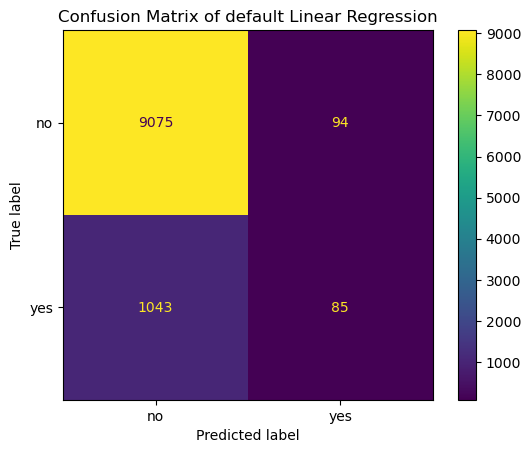

In [37]:
conf_matrix = confusion_matrix(y_test, lr.predict(X_test))
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=lr.classes_)

disp.plot()
disp.ax_.set_title("Confusion Matrix of default Linear Regression")

The simple model was good at identifying people not subscribed, picking up on 9075 of them while mis-dentifying 94, but poor at predicting non-subscribed people, only correctly identifying 85 of them while mislabeling 1043.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [40]:
start = time.time()
svc = SVC().fit(X_train,y_train)
end = time.time()
svc_train = svc.score(X_train,y_train)
svc_test = svc.score(X_test,y_test)
svc_time = end - start
print(svc_train, svc_test,svc_time)

0.8922987277847917 0.8908419928134408 70.64762282371521


In [41]:
start = time.time()
knn = KNeighborsClassifier().fit(X_train,y_train)
end = time.time()
knn_train = knn.score(X_train,y_train)
knn_test = knn.score(X_test,y_test)
knn_time = end - start
print(knn_train, knn_test,knn_time)

0.9023340131429867 0.8810333106730116 0.0349431037902832


In [42]:
start = time.time()
dt = DecisionTreeClassifier().fit(X_train,y_train)
end = time.time()
dt_train = dt.score(X_train,y_train)
dt_test = dt.score(X_test,y_test)
dt_time = end-start
print(dt_train, dt_test,dt_time)

0.9784079505357548 0.8340293289307565 0.21401190757751465


In [43]:
model_stats = pd.DataFrame({'Model':['SVC','KNN','Logistic Regression','DecisionTree','Baseline'],
                              'Train Time':[svc_time,knn_time,lr_time,dt_time,0],
                              'Train Accuracy':[svc_train,knn_train,lr_train,dt_train,baseline_acc],
                              'Test Accuracy':[svc_test,knn_test,lr_test,dt_test,baseline_acc]})
model_stats

,Model,Train Time,Train Accuracy,Test Accuracy
0,SVC,70.647623,0.892299,0.890842
1,KNN,0.034943,0.902334,0.881033
2,Logistic Regression,0.143175,0.886537,0.889579
3,DecisionTree,0.214012,0.978408,0.834029
4,Baseline,0.000000,0.887346,0.887346


SVC, or Support Vector Machine, took by far the longest at over a minute and managed an accuracy score of 89.1%, only marginally better than the baseline 88.7% and nearly equal to the simple Logstistic Regression at 88.96%. K-Nearest Neighbors and DecisionTree both did worse than the baseline, as seen in the below graph.

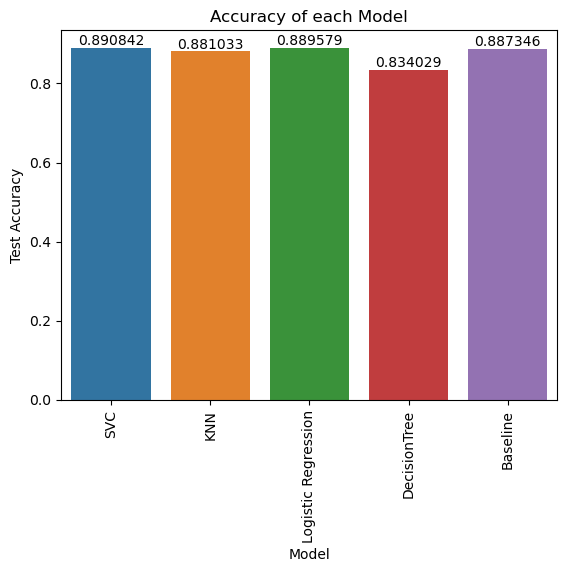

In [45]:
ax = sns.barplot(model_stats,x='Model', y='Test Accuracy')
ax.bar_label(ax.containers[0]);
ax.set_title('Accuracy of each Model')
ax.tick_params(axis='x', rotation=90)

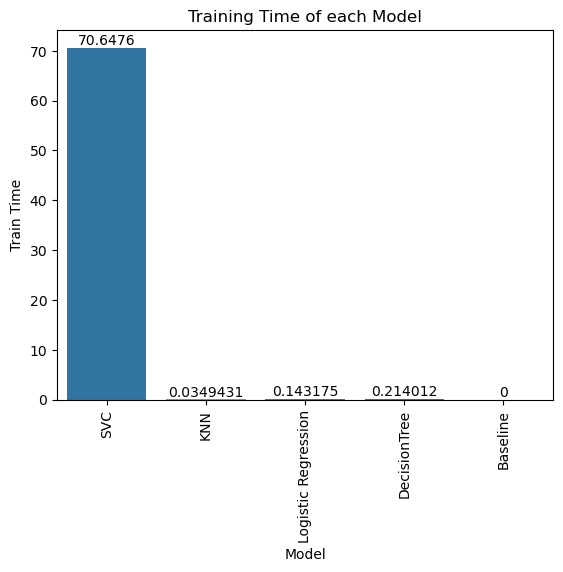

In [46]:
ax = sns.barplot(model_stats,x='Model', y='Train Time')
ax.bar_label(ax.containers[0]);
ax.set_title('Training Time of each Model')
ax.tick_params(axis='x', rotation=90)

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

Well, gender is not a feature in the dataset, so the question of whether it should be kept or not is irrelevant.

In addition, with SVC taking close to 2 orders of magnitude longer than other models yet not yielding any increase in accuracy means it will be excluded from this point forward in the interest of time. The accompanying abstract does mention SVC coming up with the best accuracy, but over the entire dataset and very likely with a different split of training and test data if not over the entire dataset. Using GridSearchCV on it would have taken hours to run, and the one time it did finish running after hours yielded a low score, and so it was deemed not worth further experimenting with.

Furthermore, it is worth thinking about whether accuracy is the best metric to be using. The bank wants to identify the subscribers and know how to identify people like them. Therefore, recall, calculated by the number of true positives divided by the sum of true positives and false negatives, is a good metric for minimizing the false negatives. In this context, false negatives are subscribers mislabelled by the model as non-subscribers and thus people the bank would miss. This is better than accuracy, which is more concerned about labelling everyone correctly, and the bank probably does not care too much about non-subscribers being labelled as subscribers as long as they are able to capture the essense of subscribers. 

First, several hyperparameters for linear regression can be tried:

In [50]:
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [1_000_000,10_000_000,100_000_000]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
recall_scorer = make_scorer(recall_score, pos_label='yes')
lr_grid = GridSearchCV(estimator=model, param_grid=grid, scoring=recall_scorer)
start = time.time()
lr_result = lr_grid.fit(X_train, y_train)
end = time.time()


In [51]:
preds = lr_result.best_estimator_.predict(X_test)
print("Best: %f using %s" % (lr_result.best_score_, lr_result.best_params_))
lr_recall = recall_score(y_test, preds,pos_label='yes')
print(lr_recall)
print(end-start, "seconds")

Best: 0.079730 using {'C': 1000000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.08244680851063829
5.99652099609375 seconds


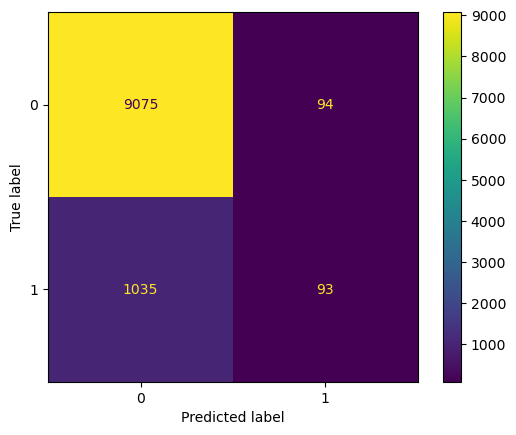

In [52]:
conf_matrix = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

Only correctly identifying 92 of the 1128 subscribers, 8.156%, is a poor performance.

Below are the coefficients by feature, whose results are surprisingly pretty similar to the default version on accuracy. Of interesting note are the illiterate customers, who are very likely to be subscribers, but their low numbers and thus low sample size in the dataset makes this a tenuous factor at best.

In [54]:
dict_lr_grid = {'Feature Names': lr_result.best_estimator_.feature_names_in_,'Coefficient': lr_result.best_estimator_.coef_[0]}
coef_series = pd.DataFrame(dict_lr_grid)
print(coef_series.sort_values(by=['Coefficient'],ascending=False))

                                     Feature Names  Coefficient
21           one hot encoder__education_illiterate     1.345316
41                      one hot encoder__month_mar     1.027135
38                      one hot encoder__month_dec     0.879178
45                      one hot encoder__month_sep     0.847485
44                      one hot encoder__month_oct     0.838447
9                     one hot encoder__job_student     0.763341
6                     one hot encoder__job_retired     0.403721
34               one hot encoder__contact_cellular     0.314368
12                    one hot encoder__job_unknown     0.204870
25                     one hot encoder__default_no     0.159587
11                 one hot encoder__job_unemployed     0.104852
0                                    stdscale__age     0.094260
16                one hot encoder__marital_unknown     0.037878
50                one hot encoder__day_of_week_wed     0.012570
15                 one hot encoder__mari

In [55]:
model = KNeighborsClassifier()
n_neighbors = [1,3,5]
weights = ['uniform', 'distance']
grid = dict(n_neighbors=n_neighbors,weights=weights)
knn_grid = GridSearchCV(estimator=model, param_grid=grid, scoring=recall_scorer) 
start = time.time()
knn_result = knn_grid.fit(X_train, y_train)
end = time.time()

In [56]:
print("Best: %f using %s" % (knn_result.best_score_, knn_result.best_params_))
knn_recall = recall_score(y_test, knn_result.best_estimator_.predict(X_test),pos_label='yes')
print(knn_recall)
print(end-start)

Best: 0.227505 using {'n_neighbors': 1, 'weights': 'uniform'}
0.24822695035460993
16.306495189666748


K-Nearest Neighbors managed a surprisingly high 24.8% test data recall.

In [58]:
model = DecisionTreeClassifier()
min_samples_split = [2,4,6,8,10]
max_depth = [14,16,18]
grid = dict(min_samples_split=min_samples_split,max_depth=max_depth)
dec_grid = GridSearchCV(estimator=model, param_grid=grid, scoring=recall_scorer) 
start = time.time()
dec_result = dec_grid.fit(X_train, y_train)
end = time.time()

/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [59]:
print("Best: %f using %s" % (dec_result.best_score_, dec_result.best_params_))
dt_recall = recall_score(y_test, dec_result.best_estimator_.predict(X_test),pos_label='yes')
print(dt_recall)
print(end-start)

Best: 0.185077 using {'max_depth': 18, 'min_samples_split': 2}
0.18351063829787234
12.687933921813965


Now, to plot recall results. Note that because the baseline model assumes no one is a subscriber, its recall score is 0 as it did not idnetify any subscribers and incorrectly identified all subscribers as not.

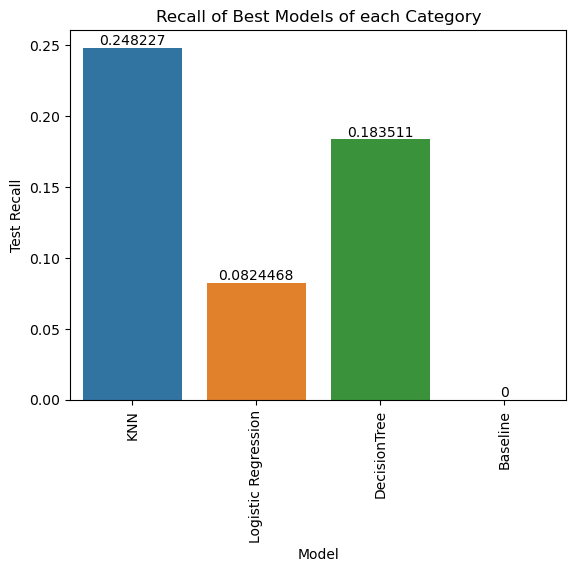

In [61]:
model_stats = pd.DataFrame({'Model':['KNN','Logistic Regression','DecisionTree','Baseline'],
                              'Test Recall':[knn_recall,lr_recall,dt_recall,0]})
ax = sns.barplot(model_stats,x='Model', y='Test Recall')
ax.bar_label(ax.containers[0]);
ax.set_title('Recall of Best Models of each Category')
ax.tick_params(axis='x', rotation=90)

K-Nearest Neighbors had by far the best recall of the 4 models including SVC (not pictured due to time contraints to run).

**Conclusions**

When looking to maximize ability to distinguish between subscribers and non-subscribers, to be accurate, Linear Regression was by far the best, being both accurate, achieving an accuracy score of 88.9%, and quickly trained in fractions of a second.

However, accuracy does not quite match up with the business objective to identify subscribers to know who to market to in the future. For that, recall is used. In this, K-Nearest Neighbors did best, correctly identifying 24.8% of the subscribers in the test dataset. Fortunately, models trained by recall as the metric identified the same customer characteristics as the accuracy based models for being most important, and so the following observations can be made.

First, contacting customers in the months of March, September, October, and December have good subscription rates, while May, July, August, and November were poor times to get people to sign up. Second, the job matters. People who were identified as students or retirees were more likely to sign up while entrepreneurs and blue collar were much less likely. Other factors, such as marital status, had much less impact.
